<a href="https://colab.research.google.com/github/veecg/recsys_preprocessing/blob/main/data_preprocess_ml100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
For each dataset (ML100k, ML1M, AmazonMovies), the ouput of the preprocessing:
- train/val/test_ui.csv 
- train/val/test_ic.csv 
- (for Amazon only) train/val/test_ir.csv 
- user_list
- item_list
- category_list


**train/val/test_ui.csv**
- Format: user_id , movie_id
- each row represents a user interaction session in chrononical order

**train/val/test_ic.csv**
- Format: movie_id , category_id

**train/val/test_ir.csv**
- Format: movie_id | related_movie_id

# Data download


In [1]:
!wget 'http://files.grouplens.org/datasets/movielens/ml-100k.zip' 
!unzip ml-100k.zip

--2021-02-24 19:14:35--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.56MB/s    in 0.8s    

2021-02-24 19:14:37 (5.56 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [2]:
# !wget 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
# !unzip ml-1m.zip
# !rm ml-1m.zip

In [3]:
# !wget 'http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Movies_and_TV.json.gz'
# !gunzip meta_Movies_and_TV.json.gz

# !wget 'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Movies_and_TV.json.gz'
# !gunzip Movies_and_TV.json.gz

# !rm meta_Movies_and_TV.json.gz
# !rm Movies_and_TV.json.gz

# Data loading

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
from math import ceil

In [5]:
# ml-100k
def read_data_ml100k(data_dir="ml-100k"):
  u_data_names = ['user_id', 'movie_id', 'rating', 'timestamp']
  u_item_names_full = ['movie_id', 'movie_title', 'release date', 
                  'video release date', 'IMDb URL' , 'unknown' , 
                  'Action' , 'Adventure' , 'Animation' , 'Children' , 
                  'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
                  'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 
                  'SciFi' , 'Thriller' , 'War' , 'Western']
  u_item_names = ['movie_id','movie_title','unknown' , 
                  'Action' , 'Adventure' , 'Animation' , 'Children' , 
                  'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
                  'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 
                  'SciFi' , 'Thriller' , 'War' , 'Western']

  ui_data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', 
                        names=u_data_names, engine='python')
  
  metadata = pd.read_csv(os.path.join(data_dir, 'u.item'), '|', 
                         names=u_item_names_full, engine='python', 
                         usecols=u_item_names)
  
  return ui_data, metadata

def split_data(data, split_ratio=0.1, split_mode='random'):
  return 0


def get_statistics_ui(interaction_data):
  num_users = interaction_data.user_id.unique().shape[0]
  num_items = interaction_data.movie_id.unique().shape[0]
  sparsity = 1 - len(interaction_data) / (num_users * num_items)
  print("Data statistics: ")
  print("- number of users:", num_users)
  print("- number of items:", num_items)
  print("- sparsity:", sparsity)



In [6]:
ui_data, metadata = read_data_ml100k()

In [7]:
print("Before cleanup:")
get_statistics_ui(ui_data)
print("- number of metadata", len(metadata))

Before cleanup:
Data statistics: 
- number of users: 943
- number of items: 1682
- sparsity: 0.9369533063577546
- number of metadata 1682


In [8]:
ui_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
metadata.head()

,movie_id,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


# Data cleanup


## Data cleanup - user-item interaction

1. Binarize ratings: Rating score >= 3 as 1, otherwise as 0
2. Remove users with less than 10 interactions (skip for Movielens)
3. Remove items with less than 10 ratings 
4. Remove users with less than 5 interactions (such that each user has at least 
5 effective ratings after cleanup, and it's enough for train:val:test split)

In [10]:
ui_data['rating_binary'] = np.where(ui_data['rating']>2, 1, 0)
counts = ui_data.movie_id.value_counts(ascending=True)
ui_data = ui_data[~ui_data['movie_id'].isin(counts[counts<5].index)]
ui_data.user_id.value_counts(ascending=True)
# no user has less than 5 interactions after step 3, skip step 4

36      19
242     19
572     20
571     20
631     20
      ... 
276    516
450    535
13     614
655    621
405    648
Name: user_id, Length: 943, dtype: int64

In [11]:
ui_data.drop(ui_data[ui_data.rating_binary==0].index, inplace=True) # drop negative interaction
ui_data['date'] = ui_data['timestamp'].apply(lambda x:datetime.fromtimestamp(x)) # convert timestamp to datetime
ui_data.sort_values(by=['user_id', 'date'], inplace=True) # order data by user/time
ui_data.head()

,user_id,movie_id,rating,timestamp,rating_binary,date
59972,1,168,5,874965478,1,1997-09-22 21:57:58
92487,1,172,5,874965478,1,1997-09-22 21:57:58
74577,1,165,5,874965518,1,1997-09-22 21:58:38
48214,1,156,4,874965556,1,1997-09-22 21:59:16
15764,1,196,5,874965677,1,1997-09-22 22:01:17


In [12]:
print("After cleanup:")
get_statistics_ui(ui_data)

After cleanup:
Data statistics: 
- number of users: 943
- number of items: 1344
- sparsity: 0.9351992122405696


## Data cleanup - metadata

1) Remove items that were removed in the user-interaction cleanup stage

In [13]:
metadata = metadata[~metadata['movie_id'].isin(counts[counts<5].index)]
print("- number of metadata", len(metadata))

- number of metadata 1349


# EDA (Exploratory data analysis)

In [14]:
eda_data = pd.merge(ui_data, metadata)
eda_data.head()

,user_id,movie_id,rating,timestamp,rating_binary,date,movie_title,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,SciFi,Thriller,War,Western
0,1,168,5,874965478,1,1997-09-22 21:57:58,Monty Python and the Holy Grail (1974),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,168,3,875636691,1,1997-09-30 16:24:51,Monty Python and the Holy Grail (1974),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,168,4,883602865,1,1997-12-31 21:14:25,Monty Python and the Holy Grail (1974),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,168,5,891351509,1,1998-03-31 13:38:29,Monty Python and the Holy Grail (1974),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,168,4,877888812,1,1997-10-26 18:00:12,Monty Python and the Holy Grail (1974),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## 25 most rated movies


In [15]:
most_rated = eda_data.groupby('movie_title').size().sort_values(ascending=False)[:25]
most_rated

movie_title
Star Wars (1977)                             558
Fargo (1996)                                 476
Return of the Jedi (1983)                    476
Contact (1997)                               454
Toy Story (1995)                             417
Raiders of the Lost Ark (1981)               403
English Patient, The (1996)                  398
Scream (1996)                                390
Godfather, The (1972)                        384
Air Force One (1997)                         380
Silence of the Lambs, The (1991)             374
Liar Liar (1997)                             365
Twelve Monkeys (1995)                        352
Pulp Fiction (1994)                          351
Empire Strikes Back, The (1980)              350
Jerry Maguire (1996)                         342
Independence Day (ID4) (1996)                335
Chasing Amy (1997)                           334
Rock, The (1996)                             332
Star Trek: First Contact (1996)              328
Back to 

## 25 most highly rated movies

In [16]:
high_rate = eda_data.groupby('movie_title').agg({'rating': [np.size, np.mean]}).sort_values([('rating', 'mean')], ascending=False)[:25]
high_rate

rating          
                                                     size      mean
movie_title                                                        
Hugo Pool (1997)                                        3  5.000000
Turbo: A Power Rangers Movie (1997)                     1  5.000000
Faust (1994)                                            4  4.750000
Year of the Horse (1997)                                4  4.750000
Mina Tannenbaum (1994)                                  4  4.750000
Braindead (1992)                                       11  4.636364
Pather Panchali (1955)                                  8  4.625000
World of Apu, The (Apur Sansar) (1959)                  5  4.600000
Aparajito (1956)                                        5  4.600000
Schindler's List (1993)                               288  4.565972
Wrong Trousers, The (1993)                            115  4.547826
Close Shave, A (1995)                                 110  4.545455
Shawshank Redemption, The (1994)                      276  4.514493
Old Lady Who Walked in the Sea, The (Vieille qu...      2  4.500000
Wallace & Gromit: The Best of Aardman Animation...     66  4.500000
Casablanca (1942)                                     241  4.481328
Star Wars (1977)                                      558  4.480287
Usual Suspects, The (1995)                            258  4.476744
Godfather, The (1972)                                 384  4.471354
Bad Taste (1987)                                       11  4.454545
Shall We Dance? (1996)                                 43  4.441860
Incognito (1997)                                        7  4.428571
Paths of Glory (1957)                                  31  4.419355
One Flew Over the Cuckoo's Nest (1975)                251  4.418327
Titanic (1997)                                        327  4.415902

## Ratings distribution

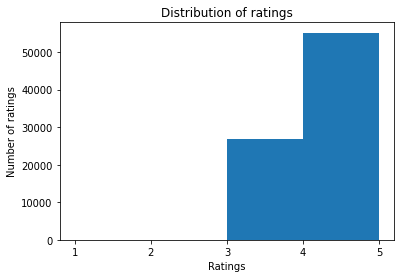

In [17]:
eda_data.rating.plot.hist(bins=range(1,6))
plt.title('Distribution of ratings')
plt.ylabel('Number of ratings')
plt.xlabel('Ratings')
_ = plt.xticks(range(1,6), range(1,6))


# Data train/eval/test split

1. Split a chrononically ordered frame as train:val:test=8:1:1


In [18]:
column_names = ['user_id', 'movie_id', 'rating', 'timestamp', 'date']
user_list = ui_data.user_id.unique()

train_df = pd.DataFrame(columns = column_names)
val_df = pd.DataFrame(columns = column_names)
test_df = pd.DataFrame(columns = column_names)

val_ratio = 0.1
test_ratio = 0.1

for u in tqdm(user_list):
  mask = ui_data['user_id'] == u
  df = ui_data[mask]
  num_val = ceil(len(df)*val_ratio)
  num_test = ceil(len(df)*test_ratio)
  num_train = len(df) - num_val - num_test
  
  train_df = pd.concat([train_df,df[:num_train]])
  val_df = pd.concat([val_df,df[num_train:num_train+num_val]])
  test_df = pd.concat([test_df, df[num_train+num_val:]])
  # train_df.append(df[:num_train], ignore_index=True)
  # val_df.append(df[num_train:num_train+num_val], ignore_index=True)
  # test_df.append(df[num_train+num_val:], ignore_index=True) 

In [19]:
train_df

,user_id,movie_id,rating,timestamp,date,rating_binary
59972,1,168,5,874965478,1997-09-22 21:57:58,1.0
92487,1,172,5,874965478,1997-09-22 21:57:58,1.0
74577,1,165,5,874965518,1997-09-22 21:58:38,1.0
48214,1,156,4,874965556,1997-09-22 21:59:16,1.0
15764,1,196,5,874965677,1997-09-22 22:01:17,1.0
...,...,...,...,...,...,...
90947,943,1044,3,888639903,1998-02-28 04:25:03,1.0
77956,943,94,4,888639929,1998-02-28 04:25:29,1.0
85027,943,218,4,888639929,1998-02-28 04:25:29,1.0
99832,943,739,4,888639929,1998-02-28 04:25:29,1.0


In [20]:
val_df

,user_id,movie_id,rating,timestamp,date,rating_binary
5233,1,125,3,878542960,1997-11-03 07:42:40,1.0
8976,1,12,5,878542960,1997-11-03 07:42:40,1.0
9811,1,201,3,878542960,1997-11-03 07:42:40,1.0
10508,1,208,5,878542960,1997-11-03 07:42:40,1.0
74847,1,116,3,878542960,1997-11-03 07:42:40,1.0
...,...,...,...,...,...,...
98422,943,672,5,888640125,1998-02-28 04:28:45,1.0
75307,943,794,3,888640143,1998-02-28 04:29:03,1.0
95132,943,67,4,888640143,1998-02-28 04:29:03,1.0
87976,943,816,4,888640186,1998-02-28 04:29:46,1.0


In [21]:
test_df

,user_id,movie_id,rating,timestamp,date,rating_binary
20175,1,9,5,878543541,1997-11-03 07:52:21,1.0
42456,1,169,5,878543541,1997-11-03 07:52:21,1.0
47539,1,178,5,878543541,1997-11-03 07:52:21,1.0
47860,1,87,5,878543541,1997-11-03 07:52:21,1.0
54634,1,16,5,878543541,1997-11-03 07:52:21,1.0
...,...,...,...,...,...,...
71561,943,237,4,888692413,1998-02-28 19:00:13,1.0
88511,943,151,4,888692699,1998-02-28 19:04:59,1.0
86663,943,840,4,888693104,1998-02-28 19:11:44,1.0
95291,943,228,3,888693158,1998-02-28 19:12:38,1.0


# Sessionize the interaction data

In [22]:
ui_data[ui_data['user_id']==302]

,user_id,movie_id,rating,timestamp,rating_binary,date
9848,302,307,4,879436739,1,1997-11-13 15:58:59
14758,302,258,3,879436739,1,1997-11-13 15:58:59
84234,302,333,3,879436785,1,1997-11-13 15:59:45
32327,302,301,4,879436820,1,1997-11-13 16:00:20
4826,302,328,3,879436844,1,1997-11-13 16:00:44
58767,302,289,3,879436874,1,1997-11-13 16:01:14
81824,302,271,4,879436911,1,1997-11-13 16:01:51
55280,302,358,3,879436981,1,1997-11-13 16:03:01


In [23]:
val_df[val_df['user_id']==302]
# train_df[train_df['user_id']==302]

,user_id,movie_id,rating,timestamp,date,rating_binary
81824,302,271,4,879436911,1997-11-13 16:01:51,1.0


In [24]:
def session(data, mode='train'):
  user_list = data.user_id.unique()
  ui_session = {user_id:[[]] for user_id in user_list}
  session_endtime = {user_id:None for user_id in user_list}

  for _, row in tqdm(ui_data.iterrows(), total=ui_data.shape[0]):
    user_id = row.user_id
    movie_id = row.movie_id

    rating_date = row.date
    last_rating_date = session_endtime[user_id]
    if last_rating_date is None:
      last_rating_date = rating_date

    if (rating_date - rating_date).days < 365 and len(ui_session[user_id][-1])<50: 
      ui_session[user_id][-1].append(movie_id)
    else:
      # one-year idle period / list longer than 50 records
      # store to a new list
      ui_session[user_id].append([movie_id])
    # update time pointer
    # because the frame is sorted 
    # for the same user, new review record must happen after the last one
    session_endtime[user_id] = rating_date 
  return ui_session

train_session = session(train_df)
val_session = session(val_df)
test_session = session(val_df)

# Save the data

In [25]:
metadata.drop(['movie_title'], axis=1, inplace=True)

In [26]:
import pickle
metadata.to_csv('/content/metadata.csv')
with open('/content/train_session.pkl', 'wb') as f:
  pickle.dump(train_session, f)
with open('/content/val_session.pkl', 'wb') as f:
  pickle.dump(val_session, f)
with open('/content/test_session.pkl', 'wb') as f:
  pickle.dump(test_session, f)
